In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import torch
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=33670beb1f8f917defc089a459b8c9f5dedcb43811d48b6e8a60c909426d907a
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 276.2 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB
True
Tesla T4


In [ ]:
!pip install transformers==3.3.0

In [2]:
import torch 
import logging
import torch.nn as nn
import numpy as np
import time
import transformers
from tqdm import tqdm
from sklearn import metrics
from transformers import AutoModel
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, f1_score
from google.colab import drive
import pandas as pd 
import torch
import numpy as np
import warnings
from sklearn import model_selection
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from collections import defaultdict
import gc
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
pd.set_option('display.max_colwidth', 255)
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
def get_module_logger(logger_name):
  formatter = logging.Formatter(
      "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
      '%Y-%m-%d %H:%M:%S'
  )
  ch = logging.StreamHandler()
  ch.setLevel(logging.DEBUG)
  ch.setFormatter(formatter)

  library_logger = logging.getLogger(logger_name)

  for logger in [library_logger]:
      logger.setLevel(logging.DEBUG)
      logger.addHandler(ch)
  return logger

In [4]:
class args:
  seed = 42
  epochs = 5
  train_batch_size = 16
  valid_batch_size = 32
  max_len = 200
  split_portion = 150
  learning_rate = 2e-5
  weight_decay = 1e-4
  classes = 1
  dropout = 0.1
  clip = 0.25
  path = '/content/drive/MyDrive/Political_Speech_Classification_Task'
  training_file = f'{path}/input/train.csv'
  testing_file = f'{path}/input/test.csv'
  output = f'{path}/input/pred_with_spliting.csv'
  unseen_file = f'{path}/input/unseen_data.csv'
  unseen_file_with_spliting = f'{path}/input/unseen_file_with_spliting.csv'
  model_specification = f'{path}/store_models/split_roberta'
  model_layer = 'last_two'
  pretrained_model_name = "roberta-base"#'roberta-large'
  roberta_hidden = 768#1024
  do_lower_case = True
  adam_epsilon = 1e-8
  warmup_steps = 0

In [5]:
args = args()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
logger = get_module_logger(__name__)

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            logger.info('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            logger.info('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

#Splitting the Data into smaller chunks¶
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//args.split_portion >0:
    n = len(text1.split())//args.split_portion
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:args.max_len]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*args.split_portion:w*args.split_portion + args.max_len]
      l_total.append(" ".join(l_parcial))
  return l_total


def data_chunking(df):
  df['text_split'] = df['text'].apply(get_split)
  text_l = []
  label_l = []
  index_l =[]
  for idx,row in df.iterrows():
    for l in row['text_split']:
      text_l.append(l)
      label_l.append(row['immigration'])
      index_l.append(idx)
        
  dataframe = pd.DataFrame({'id': index_l,'text':text_l, 'immigration':label_l})
  #dataframe['immigration'] = dataframe['immigration'].astype('float64') 
  dataframe['text_len'] = dataframe['text'].astype(str).apply(len)
  dataframe['text_word_count'] = dataframe['text'].apply(lambda x: len(str(x).split()))
  return dataframe


In [6]:
class Dataset:
    def __init__(self, text, targets):
        self.text = text
        self.tokenizer = AutoTokenizer.from_pretrained(args.pretrained_model_name, do_lower_case = args.do_lower_case)
        self.max_length = args.max_len
        self.targets = targets

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        
        text = str(self.text[item])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation_strategy="longest_first",
            pad_to_max_length=True,
            truncation=True
        )
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
       
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[item], dtype=torch.float)
        }


if __name__ == "__main__":
    df = pd.read_csv(args.training_file).dropna().reset_index(drop = True)
    dset = Dataset(
        text=df.text.values,
        targets=df.immigration.values
        )
    print(df.iloc[1]['text'])
    print(dset[1])
    # tokenizer = AutoTokenizer.from_pretrained(args.pretrained_model_name, do_lower_case=args.do_lower_case)
    # print(tokenizer.tokenize(df.iloc[1]['tweet']))
    # print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.iloc[1]['tweet'])))

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Mr. President. I have for some time now been keenly interested in the competitiveness of U.S. firms in global markets. As we look to the 21st century. there can be no doubt that the future growth of the U.S. economy depends to a very large extent on the ability of U.S. companies to integrate manufacturing. distribution. and marketing across international borders. The unification of the European Community market. the development of market economies in Eastern Europe. and the rapid growth of the Pacific rim economies create enormous opportunities and great challenges for U.S. companies in the 1990s. In view of the growing importance of international sales and operations to the U.S. economy. I have been particularly concerned about various aspecis of U.S. tax rules which cause U.S. firms to operate at a competitive disadvantage as compared to their foreign counterparts. In this regard. I introduced the Foreign Tax Simplification Act of 1991 in April of this year to simplify taxation for U

In [7]:
class RobertaLarge(nn.Module):
  def __init__(self):
    super(RobertaLarge, self).__init__()
    self.roberta = AutoModel.from_pretrained(args.pretrained_model_name,output_hidden_states=True)
    self.drop_out = nn.Dropout(args.dropout) 
    self.l0 =  nn.Linear(args.roberta_hidden * 2, 1)
    torch.nn.init.normal_(self.l0.weight, std=0.02)

  def forward(self,ids,attention_mask):
    _, _, out = self.roberta(
        ids,
        attention_mask=attention_mask
    )
    out = torch.cat((out[-1], out[-2]), dim=-1)
    out = self.drop_out(out)
    out = out[:,0,:]
    logits = self.l0(out)
    return logits


class RobertaLargeNext(nn.Module):
  def __init__(self):
    super(RobertaLargeNext, self).__init__()
    self.roberta = AutoModel.from_pretrained(args.pretrained_model_name,output_hidden_states=True)
    self.drop_out = nn.Dropout(args.dropout) 
    self.l0 =  nn.Linear(args.roberta_hidden * 4, 1)
    torch.nn.init.normal_(self.l0.weight, std=0.02)

  def _get_cls_vec(self, vec):
    return vec[:,0,:].view(-1, args.roberta_hidden)

  def forward(self,ids,attention_mask):
    _, _, hidden_states = self.roberta(
        ids,
        attention_mask=attention_mask
    )
    vec1 = self._get_cls_vec(hidden_states[-1])
    vec2 = self._get_cls_vec(hidden_states[-2])
    vec3 = self._get_cls_vec(hidden_states[-3])
    vec4 = self._get_cls_vec(hidden_states[-4])

    out = torch.cat([vec1, vec2, vec3, vec4], dim=1)
    #out = self.drop_out(out)
    logits = self.l0(out)
    return logits

In [8]:
def loss_fn(y_pred, y_true):
  return nn.BCEWithLogitsLoss()(y_pred, y_true.view(-1,1))

def train_fn(data_loader, model, optimizer, device, scheduler, n_examples):
  model.train()
  losses = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  start = time.time()
  train_losses = []
  fin_targets = []
  fin_outputs = []
  for bi, d in enumerate(tk0):
    ids = d["ids"]
    mask = d["mask"]
    targets = d["targets"]
    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.float)
    # Reset gradients
    model.zero_grad()
    outputs = model(
      ids=ids,
      attention_mask=mask
    )
    loss = loss_fn(outputs, targets)
    train_losses.append(loss.item())

    outputs = torch.round(nn.Sigmoid()(outputs)).squeeze()
    targets = targets.squeeze()
    outputs = outputs.cpu().detach().numpy().tolist()
    targets = targets.cpu().detach().numpy().tolist()
    train_f1 = f1_score(outputs, targets)
    end = time.time()

    f1 = np.round(train_f1.item(), 3)
    if (bi % 100 == 0 and bi != 0) or (bi == len(data_loader) - 1) :
      logger.info(f'bi={bi}, Train F1={f1},Train loss={loss.item()}, time={end-start}')
    
    loss.backward() # Calculate gradients based on loss
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step() # Adjust weights based on calculated gradients
    scheduler.step() # Update scheduler
    losses.update(loss.item(), ids.size(0))
    tk0.set_postfix(loss = losses.avg)
    fin_targets.extend(targets) 
    fin_outputs.extend(outputs)
  f1 = f1_score(fin_outputs, fin_targets, average='macro')
  f1 = np.round(f1.item(), 3)
  return f1, np.mean(train_losses)

def eval_fn(data_loader, model, device, n_examples):
  model.eval()
  start = time.time()
  losses = AverageMeter()
  val_losses = []
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    #tk0 = tqdm(data_loader, total=len(data_loader))
    for bi, d in enumerate(data_loader):
      ids = d["ids"]
      mask = d["mask"]
      targets = d["targets"]
      ids = ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(
          ids=ids,
          attention_mask=mask 
      )
      loss = loss_fn(outputs, targets)
      val_losses.append(loss.item())
      targets = targets.squeeze()
      outputs = torch.round(nn.Sigmoid()(outputs)).squeeze()
      
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
  f1 = f1_score(fin_outputs, fin_targets, average='macro')
  f1 = np.round(f1.item(), 3)
  logger.info("------------ Validation Evaluation Matrix --------------------")
  logger.info('Accuracy:: {}'.format(metrics.accuracy_score(fin_targets, fin_outputs)))
  logger.info('Mcc Score:: {}'.format(matthews_corrcoef(fin_targets, fin_outputs)))
  logger.info('Precision:: {}'.format(metrics.precision_score(fin_targets, fin_outputs, average='macro')))
  logger.info('Recall:: {}'.format(metrics.recall_score(fin_targets, fin_outputs, average='macro')))
  logger.info('F_score:: {}'.format(metrics.f1_score(fin_targets, fin_outputs, average='macro')))
  logger.info("------------ ------------------ --------------------")
  return f1, np.mean(val_losses)

In [9]:
def get_predictions(data_loader, model, device):
  model.eval()
  predictions = []
  real_values = []

  with torch.no_grad():
    for bi, d in enumerate(data_loader):
      ids = d["ids"]
      mask = d["mask"]
      targets = d["targets"]
      ids = ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(
          ids=ids,
          attention_mask=mask
      )
      preds = torch.round(nn.Sigmoid()(outputs)).squeeze()
      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values


def test_evaluation(model, device):
  dfx = pd.read_csv(args.testing_file).dropna().reset_index(drop=True)
  test_dataset = Dataset(
      text=dfx.text.values,
      targets=dfx.immigration.values
  )

  test_data_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=args.train_batch_size,
      shuffle=False,
      num_workers=4
  )
  y_pred, y_test = get_predictions(test_data_loader, model, device)
  dfx['y_pred'] = y_pred
  pred_test = dfx[['text','immigration','y_pred']]
  pred_test.to_csv(f'{args.output}',index = False)
  logger.info("~~~~~~~~~~~~~~~~ Test Evaluation Matrix ~~~~~~~~~~~~~~~~~~~~~~~~")
  logger.info('Mcc Score:: {}'.format(matthews_corrcoef(y_test, y_pred)))
  logger.info('Accuracy:: {}'.format(metrics.accuracy_score(y_test, y_pred)))
  logger.info('Precision:: {}'.format(metrics.precision_score(y_test, y_pred, average='macro')))
  logger.info('Recall:: {}'.format(metrics.recall_score(y_test, y_pred, average='macro')))
  logger.info('F_score:: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
  logger.info('classification_report:: {}'.format(classification_report(y_test, y_pred)))
  logger.info("~~~~~~~~~~~~~~~~ ~~~~ ~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~~")

In [10]:
def display_acc_curves(history, title):
  plt.plot(history['train_acc'], label='train accuracy')
  plt.plot(history['val_acc'], label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.ylim([0, 1])
  plt.show()

def display_loss_curves(history, title):
  plt.plot(history['train_loss'], label='train loss')
  plt.plot(history['val_loss'], label='validation loss')
  plt.title('Training and Validation loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.ylim([0, 1])
  plt.show()

2021-08-17 07:10:30 - __main__ - INFO - train len - 11364 valid len - 180


Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

2021-08-17 07:11:01 - __main__ - INFO - STARTING TRAINING - /content/drive/MyDrive/Political_Speech_Classification_Task/store_models/split_roberta
2021-08-17 07:11:01 - __main__ - INFO - Epoch 1/5
2021-08-17 07:11:01 - __main__ - INFO - ----------


STARTING TRAINING ...



100%|██████████| 711/711 [13:24<00:00,  1.13s/it, loss=0.407]
2021-08-17 07:24:26 - __main__ - INFO - Train loss 0.40708014421929956 Train accuracy 0.766
2021-08-17 07:24:45 - __main__ - INFO - ------------ Validation Evaluation Matrix --------------------
2021-08-17 07:24:45 - __main__ - INFO - Accuracy:: 0.8611111111111112
2021-08-17 07:24:45 - __main__ - INFO - Mcc Score:: 0.7459797417891416
2021-08-17 07:24:45 - __main__ - INFO - Precision:: 0.8725
2021-08-17 07:24:45 - __main__ - INFO - Recall:: 0.8734803860132849
2021-08-17 07:24:45 - __main__ - INFO - F_score:: 0.8611068242847002
2021-08-17 07:24:45 - __main__ - INFO - ------------ ------------------ --------------------
2021-08-17 07:24:45 - __main__ - INFO - Val loss 0.30972608427206677 Val accuracy 0.861
2021-08-17 07:25:22 - __main__ - INFO - ~~~~~~~~~~~~~~~~ Test Evaluation Matrix ~~~~~~~~~~~~~~~~~~~~~~~~
2021-08-17 07:25:22 - __main__ - INFO - Mcc Score:: 0.6007749117509227
2021-08-17 07:25:22 - __main__ - INFO - Accuracy:

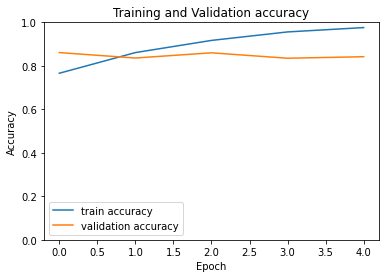

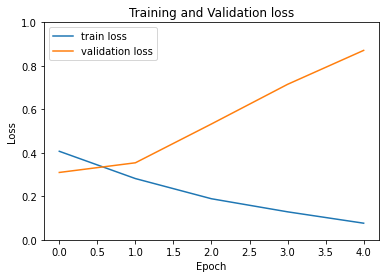

2021-08-17 08:20:16 - __main__ - INFO - ##################################### Task End ############################################


6152


In [11]:
def run():
  dfx = pd.read_csv(args.training_file).dropna().reset_index(drop=True)

  df_train, df_valid = model_selection.train_test_split(
      dfx, 
      test_size=0.1, 
      random_state=args.seed, 
      stratify=dfx.immigration.values
  )
  df_train = df_train.reset_index(drop=True)
  df_train = data_chunking(df_train)

  df_valid = df_valid.reset_index(drop=True)
  logger.info("train len - {} valid len - {}".format(len(df_train), len(df_valid)))

  train_dataset = Dataset(
      text=df_train.text.values,
      targets=df_train.immigration.values
  )

  train_data_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=args.train_batch_size,
      shuffle=True,
      num_workers=4
  )

  valid_dataset = Dataset(
      text=df_valid.text.values,
      targets=df_valid.immigration.values
  )

  valid_data_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=args.valid_batch_size,
      shuffle=False,
      num_workers=2
  )
  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  if args.model_layer == "last_two":
      model = RobertaLarge()
  else:
      model = RobertaLargeNext()
  model.to(device)
  

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  # Define two sets of parameters: those with weight decay, and those without
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(
      len(df_train) / args.train_batch_size * args.epochs)

  optimizer = AdamW(optimizer_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
  '''
  Create a scheduler to set the learning rate at each training step
  "Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period." (https://pytorch.org/docs/stable/optim.html)
  Since num_warmup_steps = 0, the learning rate starts at 3e-5, and then linearly decreases at each training step
  '''
  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=args.warmup_steps,
      num_training_steps=num_train_steps
  )
  #es = utils.EarlyStopping(patience=15, mode="max")
  print("STARTING TRAINING ...\n")
  logger.info("{} - {}".format("STARTING TRAINING",args.model_specification))
  history = defaultdict(list)
  best_accuracy = 0
  for epoch in range(args.epochs):
    logger.info(f'Epoch {epoch + 1}/{args.epochs}')
    logger.info('-' * 10)

    train_acc, train_loss = train_fn(train_data_loader, model, optimizer, device, scheduler, len(df_train))
    logger.info(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_fn(valid_data_loader, model, device, len(df_valid))
    logger.info(f'Val loss {val_loss} Val accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), f"{args.model_specification}.bin")
      best_accuracy = val_acc
      test_evaluation(model, device)
      #unseen_data_prediction(model,device)

  
  display_acc_curves(history, "acc_curves")
  display_loss_curves(history, "loss_curves")
  del model, train_data_loader, valid_data_loader, train_dataset, valid_dataset
  torch.cuda.empty_cache()
  torch.cuda.synchronize()
  logger.info("##################################### Task End ############################################")
  print(gc.collect())

if __name__ == "__main__":
  run()

### Inferences for unseen data

In [ ]:
def unseen_data_prediction(model, device):
  dfx = pd.read_csv(args.unseen_file)
  dfx['immigration'] = 0
  test_dataset = Dataset(
      text=dfx.text.values,
      targets=dfx.immigration.values
  )

  data_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=args.train_batch_size,
      shuffle=False,
      num_workers=4
  )
  y_pred = get_predictions(data_loader, model, device)
  dfx['prediction'] = y_pred
  pred_test = dfx[['text','prediction']]
  pred_test.to_csv(f'{args.unseen_file_with_spliting}',index = False)

In [ ]:
dfx = pd.read_csv(args.unseen_file)
dfx['immigration'] = 0
test_dataset = Dataset(
    text=dfx.text.values,
    targets=dfx.immigration.values
)

data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.train_batch_size*6,
    shuffle=False,
    num_workers=4
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if args.model_layer == "last_two":
  model = RobertaLarge()
else:
  model = RobertaLargeNext()
model.to(device)
  
model.load_state_dict(torch.load(f"{args.model_specification}.bin"))

y_pred, y_test = get_predictions(data_loader, model, device)
dfx['prediction'] = y_pred
pred_test = dfx[['text','prediction']]
pred_test.to_csv(f'{args.unseen_file_with_spliting}',index = False)